# Correspondence analysis

In [38]:
import json
import numpy as np
import pandas as pd
import prince
import matplotlib.pyplot as plt

In [39]:
files = ['topaz-data732--all--www.fdesouche.com--20190101--20211231.json',
    'topaz-data732--all--fr.sputniknews.africa--20190101--20211231.json',
 'topaz-data732--all--french.presstv.ir--20190101--20211231.json',
 'topaz-data732--all--www.egaliteetreconciliation.fr--20190101--20211231.json',
 ]

site_names = ['fdesouche', 'sputniknews', 'french.presstv', 'egaliteetreconciliation']

In [40]:
data = {}

for i, file in enumerate(files):
    with open(f"../data/{file}") as f:
        data[site_names[i]] = json.load(f)

In [41]:
data_type = 'kws'

In [42]:
data.keys()

dict_keys(['fdesouche', 'sputniknews', 'french.presstv', 'egaliteetreconciliation'])

## Getting the total number of words

In [43]:
word_freq = {}

In [44]:
for site in data:
    word_freq[site] = {}
    word_freq[site]["word"] = np.array(list(data[site]['metadata-all']['fr']['all'][data_type].keys()))
    word_freq[site]["freq"] = np.array(list(data[site]['metadata-all']['fr']['all'][data_type].values()))


In [45]:
for site in word_freq:
    freq_arr = word_freq[site]["freq"]
    word_arr = word_freq[site]["word"]

    mean_freq = np.mean(freq_arr)

    word_freq[site]["freq"] = freq_arr[freq_arr > mean_freq]
    word_freq[site]["word"] = word_arr[freq_arr > mean_freq]


In [46]:
for site in word_freq:
    print(f"Number of words {site}: {len(word_freq[site]['freq'])}")

Number of words fdesouche: 6543
Number of words sputniknews: 10119
Number of words french.presstv: 3959
Number of words egaliteetreconciliation: 6358


In [47]:
from functools import reduce

In [48]:
# Union of every words
word_list = reduce(np.union1d, [word_freq[site]["word"] for site in word_freq])

In [49]:
len(word_list)

11795

In [50]:
matrix = np.zeros((len(word_list), len(list(word_freq.keys()))))

In [51]:
matrix.shape

(11795, 4)

In [52]:
for i, word in enumerate(word_list):
    for j, site in enumerate(word_freq):
        index = np.where(word_freq[site]["word"] == word)[0]
        if len(index) == 0:
            matrix[i][j] = 0
        else:
            matrix[i][j] = word_freq[site]["freq"][index]



In [53]:
dataFrame = pd.DataFrame(matrix, columns=pd.Series(site_names), index=pd.Series(word_list))

In [54]:
dataFrame.head()

,fdesouche,sputniknews,french.presstv,egaliteetreconciliation
Monsieur,364.0,943.0,121.0,675.0
aaron,0.0,65.0,0.0,0.0
ababil,0.0,0.0,88.0,0.0
abandon,131.0,511.0,96.0,137.0
abattage,89.0,123.0,0.0,0.0


In [55]:
dataFrame.shape

(11795, 4)

## Applying correspondence analysis

In [56]:
ca = prince.CA(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
)

In [57]:
ca = ca.fit(dataFrame)

In [58]:
ca.row_coordinates(dataFrame).head()

,0,1
Monsieur,-0.471881,-0.512701
aaron,-0.386792,0.812961
ababil,1.776762,-0.304586
abandon,-0.293469,-0.042498
abattage,-0.655716,0.057042


In [59]:
ca.column_coordinates(dataFrame).head()

,0,1
fdesouche,-0.499981,-0.284576
sputniknews,-0.188236,0.234241
french.presstv,0.864676,-0.087761
egaliteetreconciliation,-0.337881,-0.618299


In [77]:
from prince import util
from prince import plot

def plot_coordinates(self, X, ax=None, figsize=(6, 6), x_component=0, y_component=1,
                                   show_row_labels=True, show_col_labels=True, **kwargs):
        """Plot the principal coordinates."""


        self._check_is_fitted()

        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)

        # Add style
        ax = plot.stylize_axis(ax)

        # Get labels and names
        row_label, row_names, col_label, col_names = util.make_labels_and_names(X)

        # Plot row principal coordinates
        row_coords = self.row_coordinates(X)

        x_row = row_coords[x_component]
        y_row = row_coords[y_component]

        ax.scatter(
            row_coords[x_component],
            row_coords[y_component],
            **kwargs,
            label=row_label,
            c="#d6d6d6"
        )

        # Plot column principal coordinates
        col_coords = self.column_coordinates(X)
        ax.scatter(
            col_coords[x_component],
            col_coords[y_component],
            **kwargs,
            label=col_label
        )

        texts = []
        # Add row labels
        if show_row_labels:
            x = row_coords[x_component]
            y = row_coords[y_component]
            for xi, yi, label in zip(x, y, row_names):
                # ax.annotate(label, (xi, yi))
                texts.append((xi, yi, label))

        sites = []
        # Add column labels
        if show_col_labels:
            x = col_coords[x_component]
            y = col_coords[y_component]
            for xi, yi, label in zip(x, y, col_names):
                sites.append((xi, yi, label))

        # Text
        ax.set_title('Principal coordinates')
        ei = self.explained_inertia_
        ax.set_xlabel('Component {} ({:.2f}% inertia)'.format(x_component, 100 * ei[x_component]))
        ax.set_ylabel('Component {} ({:.2f}% inertia)'.format(y_component, 100 * ei[y_component]))

        return ax, texts, sites, x_row, y_row, row_names

prince.CA.plot_coordinates = plot_coordinates


In [61]:
import itertools

def process(input_list, threshold=(10,10)):
    combos = itertools.combinations(input_list, 2)
    points_to_remove = [point2
                        for point1, point2 in combos
                        if abs(point1[0]-point2[0])<=threshold[0] and abs(point1[1]-point2[1])<=threshold[1]]
    points_to_keep = [point for point in input_list if point not in points_to_remove]
    return points_to_keep

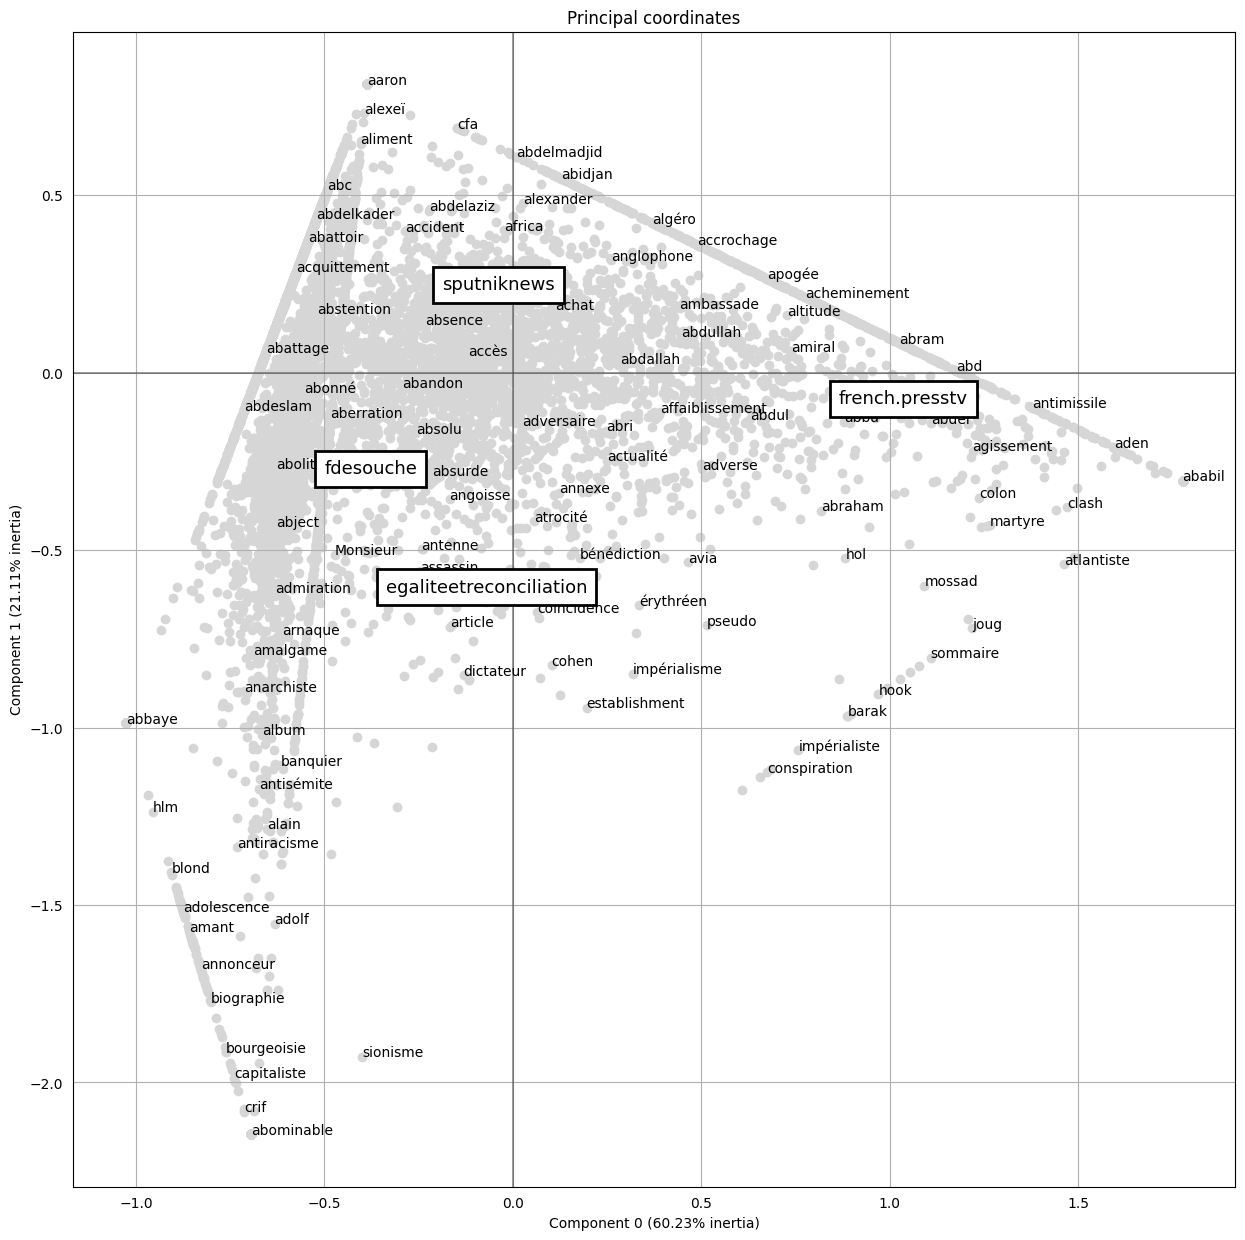

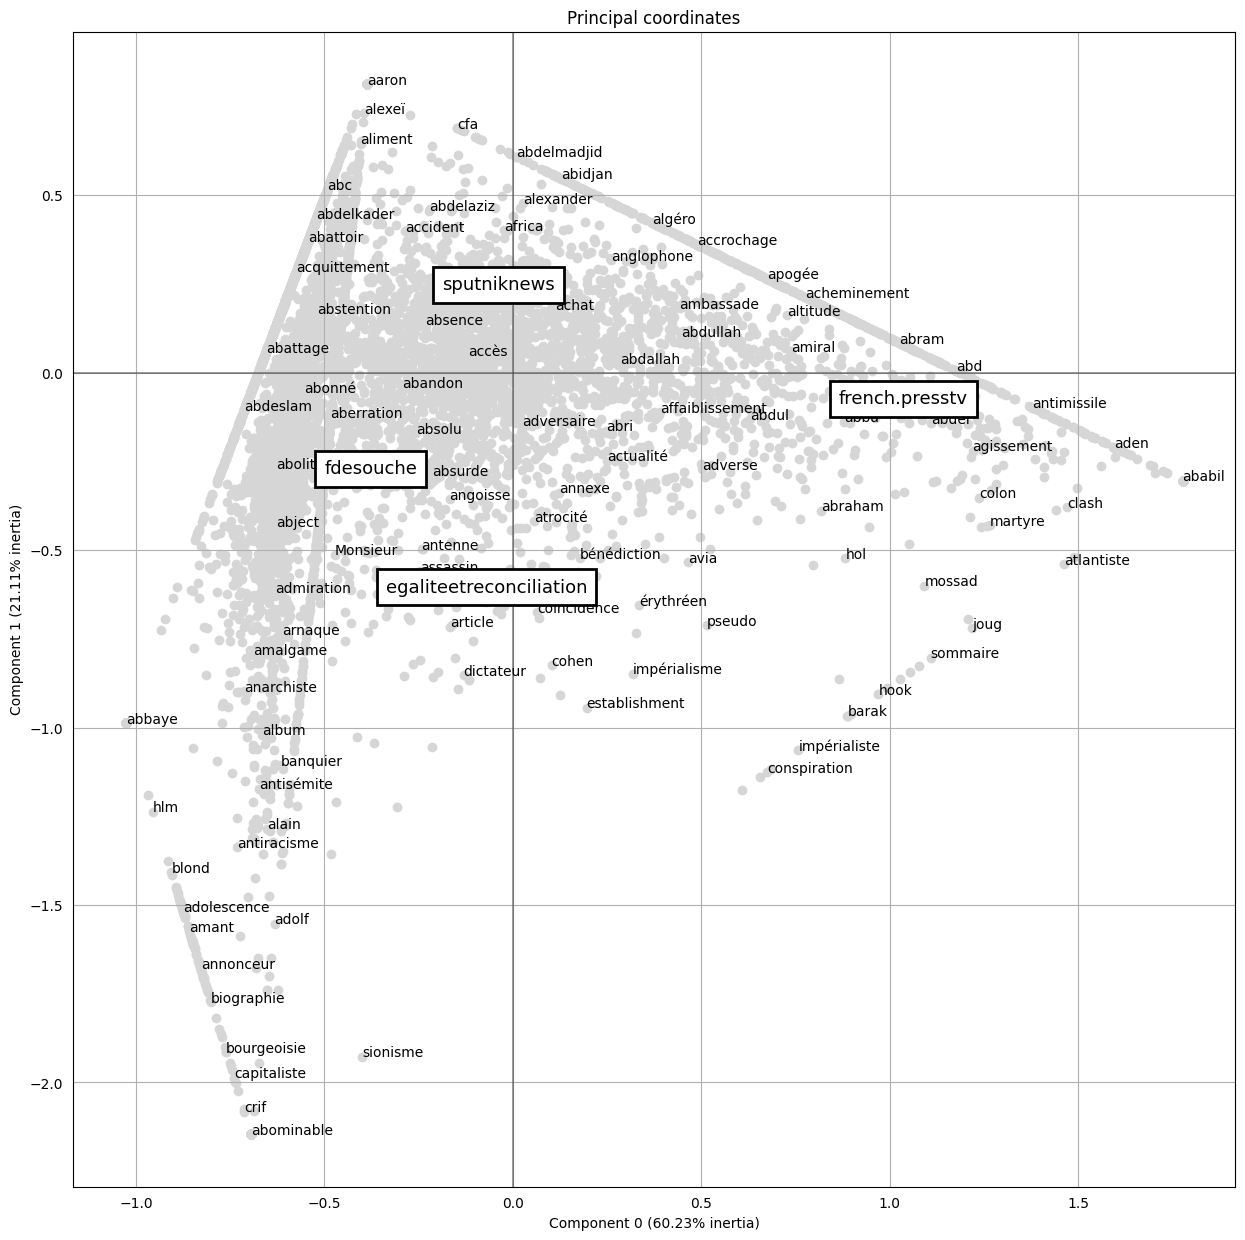

In [78]:
ax, texts, sites, x_row, y_row, row_names = ca.plot_coordinates(
    X=dataFrame,
    ax=None,
    figsize=(15, 15),
    x_component=0,
    y_component=1,
    show_row_labels=True,
    show_col_labels=True,
 )
res = process(texts, threshold=(0.20, 0.050))
for x, y, label in res:
    ax.annotate(label, (x, y))#, va='center', ha='center')

for xi, yi, label in sites:
    ax.annotate(label, (xi, yi), size=13, bbox=dict(boxstyle="square,pad=0.5", fc="white", ec="black", lw=2))
ax.get_figure()#.savefig('../img/CA-ALL-PER-ABOVE-AVG-WITH-LABELS.svg')

# Clustering data

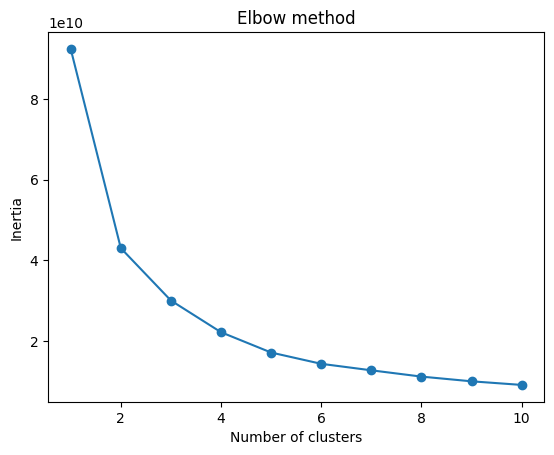

In [70]:
from sklearn.cluster import KMeans

data = dataFrame
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


In [90]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(data)


KMeans(n_clusters=4)

In [91]:
len(row_names)

11795

In [92]:
colors = np.full(len(row_names), np.nan)

In [93]:
for i, c in enumerate(kmeans.labels_):
    colors[row_names.index(word_list[i])] = c

In [94]:
np.sum(np.isnan(colors))

0

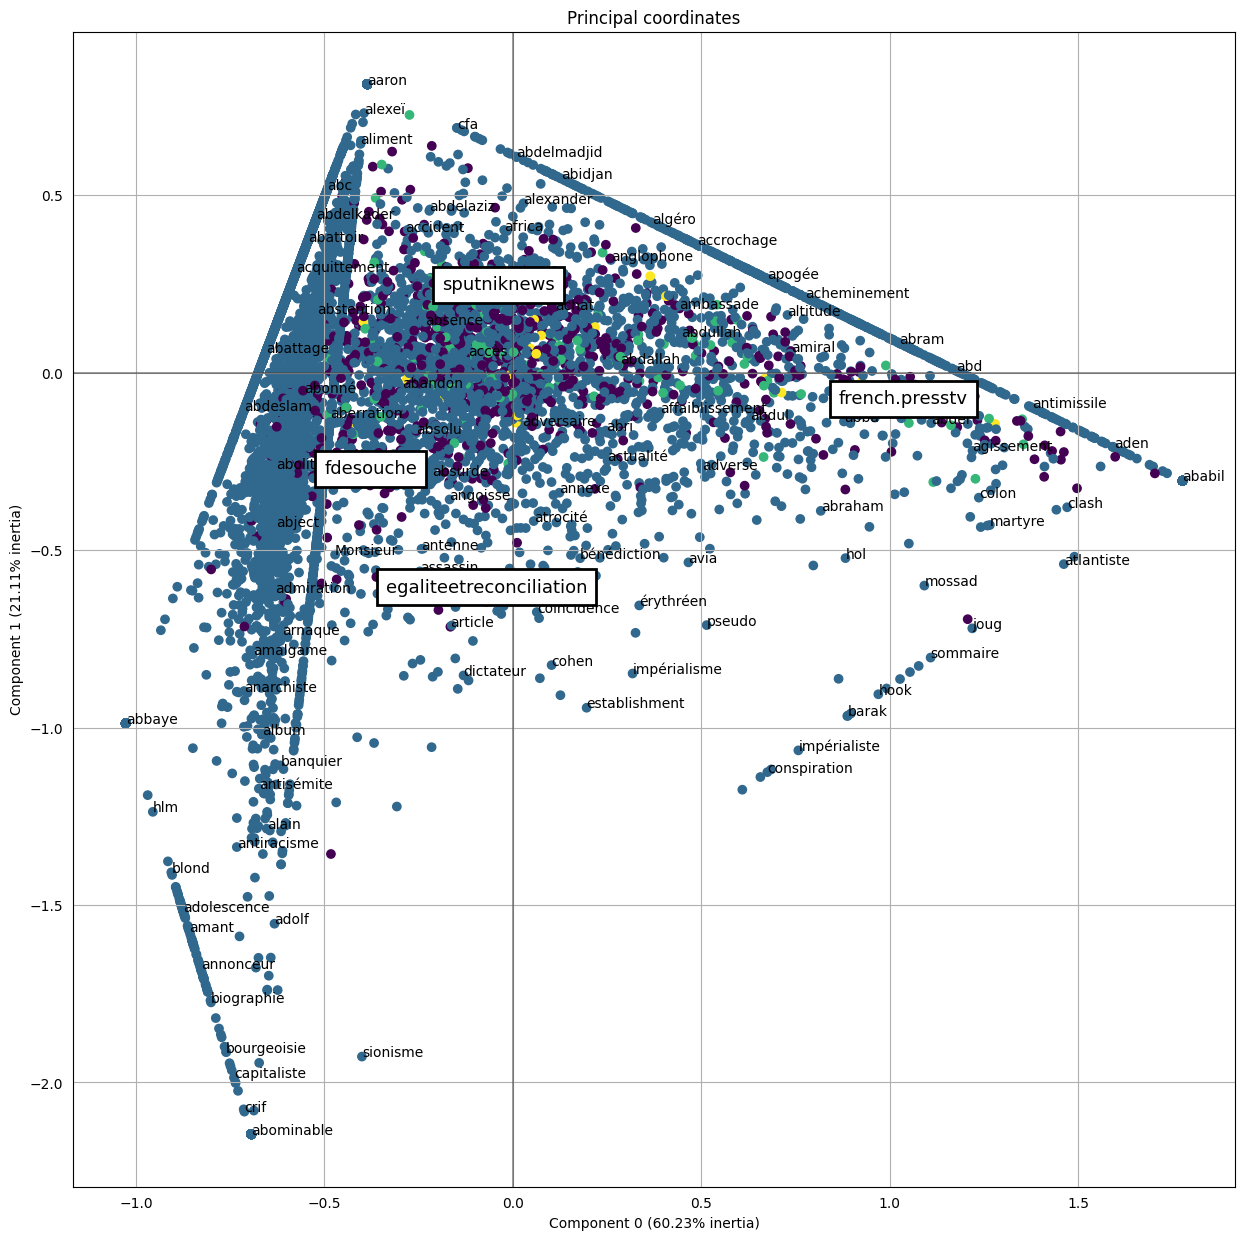

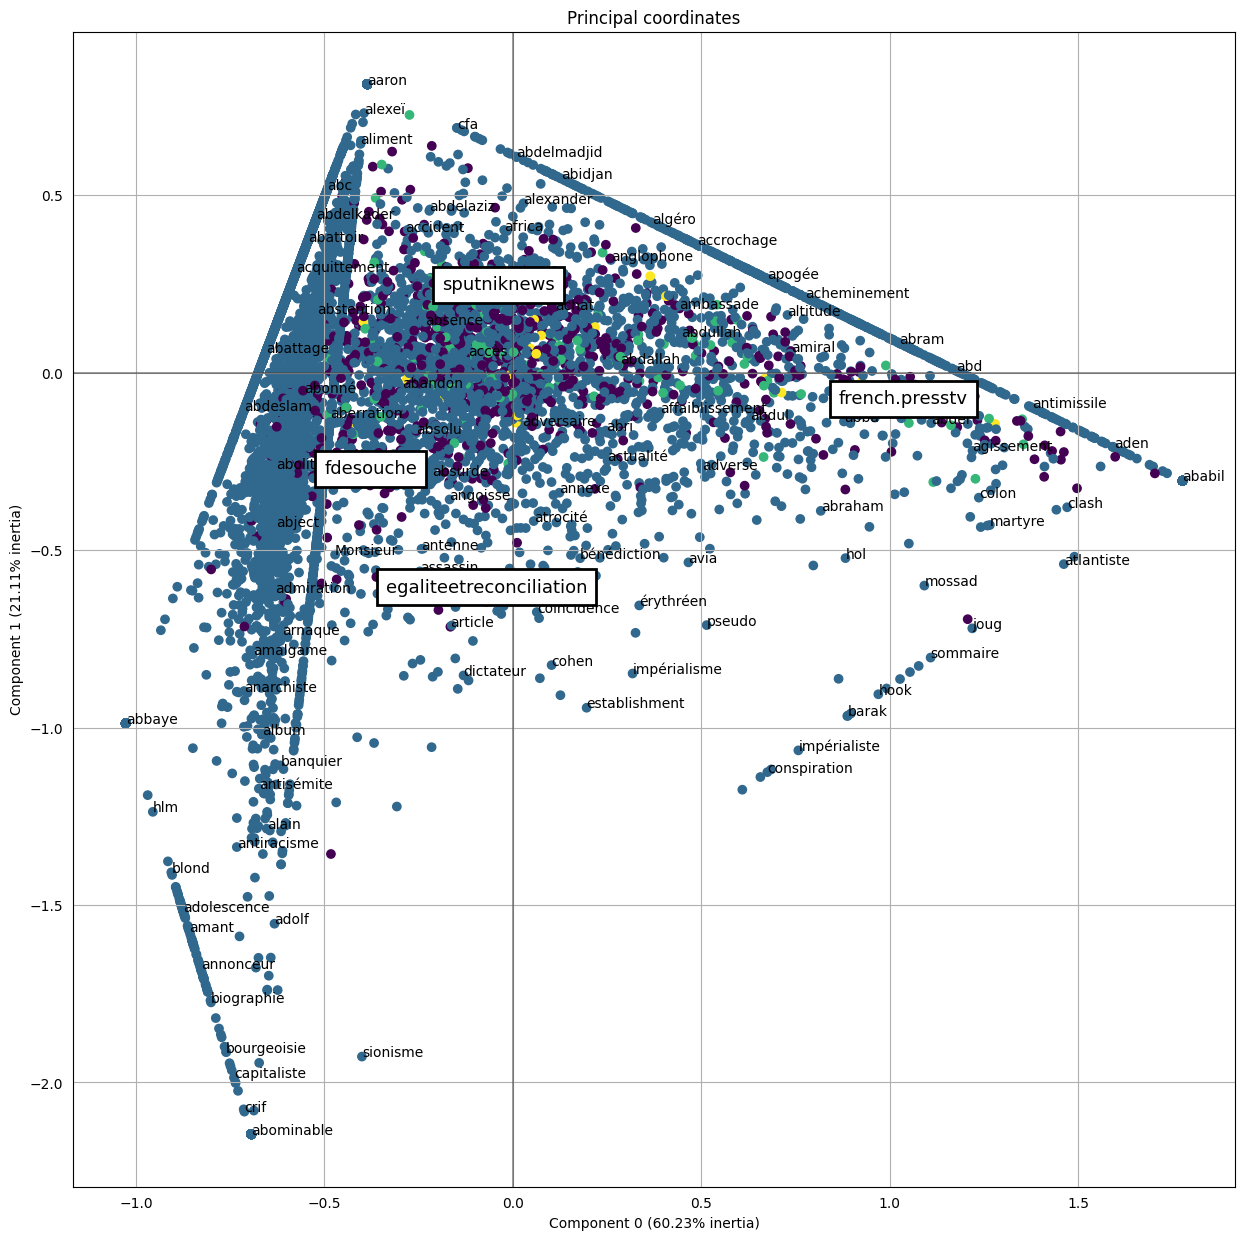

In [95]:
def plot_coordinates(self, X, ax=None, figsize=(6, 6), x_component=0, y_component=1,
                     show_row_labels=True, show_col_labels=True, **kwargs):
    """Plot the principal coordinates."""

    self._check_is_fitted()

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Add style
    ax = plot.stylize_axis(ax)

    # Get labels and names
    row_label, row_names, col_label, col_names = util.make_labels_and_names(X)

    # Plot row principal coordinates
    row_coords = self.row_coordinates(X)

    x_row = row_coords[x_component]
    y_row = row_coords[y_component]

    ax.scatter(
        row_coords[x_component],
        row_coords[y_component],
        **kwargs,
        label=row_label,
        c=colors
    )

    # Plot column principal coordinates
    col_coords = self.column_coordinates(X)
    ax.scatter(
        col_coords[x_component],
        col_coords[y_component],
        **kwargs,
        label=col_label
    )

    texts = []
    # Add row labels
    if show_row_labels:
        x = row_coords[x_component]
        y = row_coords[y_component]
        for xi, yi, label in zip(x, y, row_names):
            # ax.annotate(label, (xi, yi))
            texts.append((xi, yi, label))

    sites = []
    # Add column labels
    if show_col_labels:
        x = col_coords[x_component]
        y = col_coords[y_component]
        for xi, yi, label in zip(x, y, col_names):
            sites.append((xi, yi, label))

    # Text
    ax.set_title('Principal coordinates')
    ei = self.explained_inertia_
    ax.set_xlabel('Component {} ({:.2f}% inertia)'.format(x_component, 100 * ei[x_component]))
    ax.set_ylabel('Component {} ({:.2f}% inertia)'.format(y_component, 100 * ei[y_component]))

    return ax, texts, sites, x_row, y_row


prince.CA.plot_coordinates = plot_coordinates

import itertools


def process(input_list, threshold=(10, 10)):
    combos = itertools.combinations(input_list, 2)
    points_to_remove = [point2
                        for point1, point2 in combos
                        if abs(point1[0] - point2[0]) <= threshold[0] and abs(point1[1] - point2[1]) <= threshold[1]]
    points_to_keep = [point for point in input_list if point not in points_to_remove]
    return points_to_keep


ax, texts, sites, x_row, y_row = ca.plot_coordinates(
    X=dataFrame,
    ax=None,
    figsize=(15, 15),
    x_component=0,
    y_component=1,
    show_row_labels=True,
    show_col_labels=True,
)
res = process(texts, threshold=(0.20, 0.050))
for x, y, label in res:
    ax.annotate(label, (x, y))  #, va='center', ha='center')

for xi, yi, label in sites:
    ax.annotate(label, (xi, yi), size=13, bbox=dict(boxstyle="square,pad=0.5", fc="white", ec="black", lw=2))
ax.get_figure()  #.savefig('../img/CA-ALL-PER-ABOVE-AVG-WITH-LABELS.svg')
